In [0]:
  !pip3 install tensorflow==2.0.0.beta

     |████████████████████████████████| 87.9MB 115kB/s 
     |████████████████████████████████| 3.1MB 37.1MB/s 
     |████████████████████████████████| 501kB 45.1MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd


print ("check TensorFlow version: ", tf.__version__)
print ("check Numpy version: ", np.__version__)
print ("Check Matplotlib Version: ", matplotlib.__version__)
print ("Check Pandas Version: ", pd.__version__)

check TensorFlow version:  2.0.0-beta0
check Numpy version:  1.17.4
Check Matplotlib Version:  3.1.2
Check Pandas Version:  0.25.3


##### Mount the Drive and Load the Sunspot Csv File 

In [0]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls '/content/gdrive/My Drive/Colab Notebooks/Time_Series/Time_SeriesW4/'

LSTM_Conv1D_Week4.ipynb       LSTM_schematic.jpeg  Sunspot_W4.ipynb
LSTM_schematic1_formulas.png  Sunspots.csv	   time_series_LSTM.png


In [0]:
Sunspot_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Time_Series/Time_SeriesW4/Sunspots.csv', sep=',', )
Sunspot_df.head(3) 

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7


In [0]:
print ("shape of dataframe: ", Sunspot_df.shape)
print ("check for null values :", Sunspot_df.isnull().values.any())
print ("column names: ", list(Sunspot_df.columns.values))

shape of dataframe:  (3235, 3)
check for null values : False
column names:  ['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number']


In [0]:
#### Change Some Column Names 

Sunspot_df.rename(columns={'Monthly Mean Total Sunspot Number':'Mean Sunspot Number'}, inplace=True)
Sunspot_df.tail(4)

,Unnamed: 0,Date,Mean Sunspot Number
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9
3234,3234,2018-07-31,1.6


In [0]:
print ("Mean value of the sunspot number: ", Sunspot_df["Mean Sunspot Number"].mean()) 
print ("Minimum value of the sunspot number: ", Sunspot_df["Mean Sunspot Number"].max())
print ("Maximum value of the sunspot number: ", Sunspot_df["Mean Sunspot Number"].min())

Mean value of the sunspot number:  82.48108191653796
Minimum value of the sunspot number:  398.2
Maximum value of the sunspot number:  0.0


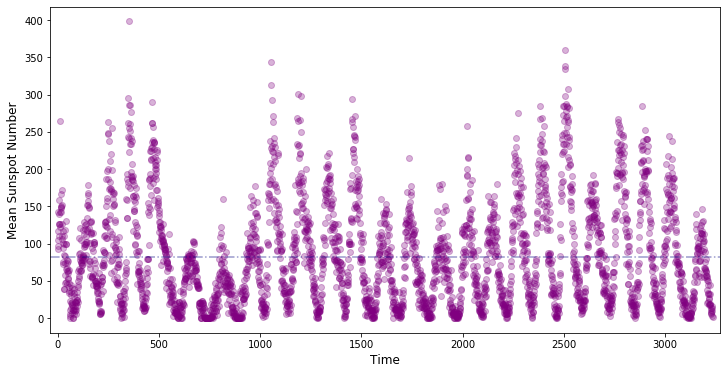

In [0]:
mean_val = Sunspot_df["Mean Sunspot Number"].mean()
plt.figure(figsize=(12, 6))

Sunspot_df["Mean Sunspot Number"].plot(linestyle='', marker='o', alpha=0.3, color='purple')
plt.xlim(-36.9, 3270)
plt.axhline(y=mean_val, linestyle='-.', color='navy', alpha=0.4)
plt.ylabel("Mean Sunspot Number", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.show()

In [0]:
Sunspot_df["Mean Sunspot Number"].value_counts(bins=10)

(-0.399, 39.82]     1101
(39.82, 79.64]       724
(79.64, 119.46]      559
(119.46, 159.28]     373
(159.28, 199.1]      250
(199.1, 238.92]      139
(238.92, 278.74]      65
(278.74, 318.56]      19
(318.56, 358.38]       3
(358.38, 398.2]        2
Name: Mean Sunspot Number, dtype: int64

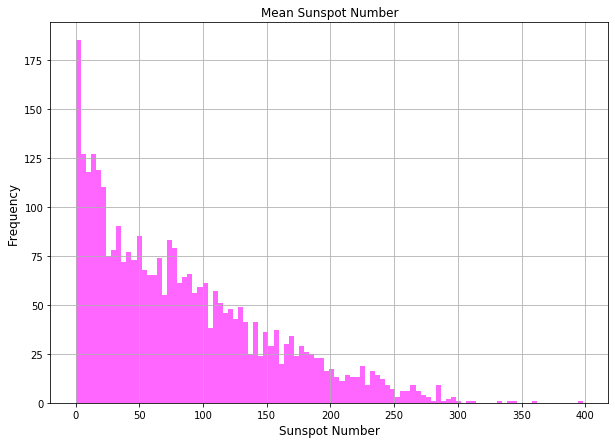

In [0]:
#### Let's Check the Distribution of the Values

fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
Sunspot_df.hist(column="Mean Sunspot Number", bins=100, color='magenta', alpha=0.6, ax = ax)
# plt.yscale('log')
plt.xlabel("Sunspot Number", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

Inference: Dividing the Mean sunspot numbers within 10 bins shows that -- Most of the Mean Sunspot numbers are between 0 to 40. Histogram plot confirms that. 

#### Divide Features and Labels 

In [0]:
sunspot_array = Sunspot_df[["Mean Sunspot Number"]].to_numpy()
print ("length of sunspot array: ", len(sunspot_array))
print ("some values: ", sunspot_array[500:510])
time_stamps = Sunspot_df[["Unnamed: 0"]].to_numpy()
print ("corresponding values of time stamps: ", time_stamps[500:510])

length of sunspot array:  3235
some values:  [[128.8]
 [140.5]
 [136.7]
 [123.3]
 [121.2]
 [103.3]
 [123.3]
 [128.7]
 [122.8]
 [107. ]]
corresponding values of time stamps:  [[500]
 [501]
 [502]
 [503]
 [504]
 [505]
 [506]
 [507]
 [508]
 [509]]


#### Create the Window Dataset Function

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

#### Helper Code Block to Understand the Window Dataset Function

In [0]:
a = tf.data.Dataset.range(14)
a = a.window(3, shift=2, drop_remainder=True)
a = a.flat_map(lambda x: x.batch(3))

print ("windowed and batch size if 3: \n")
for ele in a:
  print (ele.numpy())



##### Shuffle and separate features and labels 

a_ds = a.shuffle(2).map(lambda x: (x[:-1], x[-1]))

print ("shuffled and separated in features and labels: \n")

for ele_ds in a_ds:
  print (ele_ds)


a_ds = a_ds.batch(2).prefetch(2)

print ("Creating 3 batches of features and labels: \n")
for f in a_ds:
  print(f)


windowed and batch size if 3: 

[0 1 2]
[2 3 4]
[4 5 6]
[6 7 8]
[ 8  9 10]
[10 11 12]
shuffled and separated in features and labels: 

(<tf.Tensor: id=58, shape=(2,), dtype=int64, numpy=array([0, 1])>, <tf.Tensor: id=59, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=62, shape=(2,), dtype=int64, numpy=array([4, 5])>, <tf.Tensor: id=63, shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: id=66, shape=(2,), dtype=int64, numpy=array([6, 7])>, <tf.Tensor: id=67, shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: id=70, shape=(2,), dtype=int64, numpy=array([8, 9])>, <tf.Tensor: id=71, shape=(), dtype=int64, numpy=10>)
(<tf.Tensor: id=74, shape=(2,), dtype=int64, numpy=array([2, 3])>, <tf.Tensor: id=75, shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: id=78, shape=(2,), dtype=int64, numpy=array([10, 11])>, <tf.Tensor: id=79, shape=(), dtype=int64, numpy=12>)
Creating 3 batches of features and labels: 

(<tf.Tensor: id=93, shape=(2, 2), dtype=int64, numpy=
array([[0, 1],
       [4, 5]])>, <tf.Tensor: id=

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
split_time = 3000
time_train = time_stamps[:split_time]
x_train = sunspot_array[:split_time]
time_valid = time_stamps[split_time:]
x_valid = sunspot_array[split_time:]

window_size = 20
batch_size = 64
shuffle_buffer_size = 1000

In [0]:
train_dataset = windowed_dataset(x_train, window_size=20, batch_size=64, shuffle_buffer=shuffle_buffer_size)
print (x_train.shape)

(3000, 1)


#### Model Building-- Conv, LSTM, Dense, Lambda Layers 

In [0]:
model = tf.keras.models.Sequential([
                                    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
                                    # tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),   
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)), 
                                    tf.keras.layers.Dense(20),
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

In [0]:
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10** (epoch / 20)))

optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, rho=0.92)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])

history = model.fit(train_dataset, epochs=135, callbacks=[learning_rate])

Epoch 1/135
47/47 [==============================] - 8s 175ms/step - loss: 70.2189 - mae: 70.5805
Epoch 2/135
47/47 [==============================] - 4s 76ms/step - loss: 70.1137 - mae: 70.4782
Epoch 3/135
47/47 [==============================] - 4s 75ms/step - loss: 70.0041 - mae: 70.3690
Epoch 4/135
47/47 [==============================] - 4s 75ms/step - loss: 69.8830 - mae: 70.2483
Epoch 5/135
47/47 [==============================] - 4s 75ms/step - loss: 69.7491 - mae: 70.1146
Epoch 6/135
47/47 [==============================] - 3s 74ms/step - loss: 69.6001 - mae: 69.9656
Epoch 7/135
47/47 [==============================] - 3s 73ms/step - loss: 69.4334 - mae: 69.7987
Epoch 8/135
47/47 [==============================] - 4s 76ms/step - loss: 69.2460 - mae: 69.6111
Epoch 9/135
47/47 [==============================] - 3s 74ms/step - loss: 69.0365 - mae: 69.4016
Epoch 10/135
47/47 [==============================] - 3s 73ms/step - loss: 68.8030 - mae: 69.1682
Epoch 11/135
47/47 [========

In [0]:
print ("minimum value of loss: ", min(history.history['loss']))
min_indcs = [i for i, x in enumerate(history.history['loss']) if x==min(history.history['loss'])]
final_lr = history.history['lr'][min_indcs[0]]
print ("corresponding index: ", min_indcs)
print ("corresponding learning rate: ", history.history['lr'][min_indcs[0]])

minimum value of loss:  19.726033043061328
corresponding index:  [72]
corresponding learning rate:  3.981072e-05


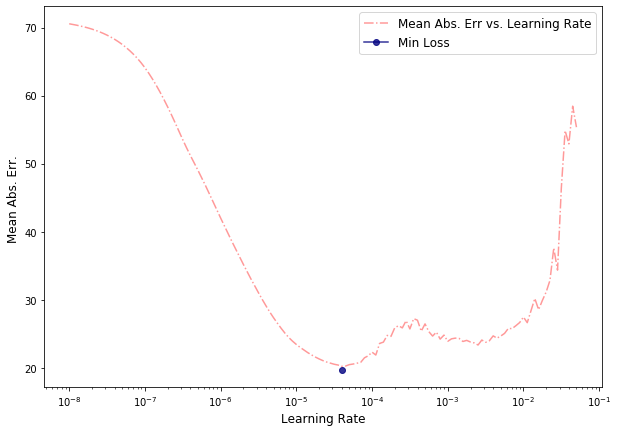

In [0]:

fig = plt.figure(figsize=(10, 7))
plt.semilogx(history.history['lr'], history.history['mae'], linestyle='-.', color='red', alpha=0.4, label='Mean Abs. Err vs. Learning Rate')
plt.plot(final_lr, min(history.history['loss']), marker='o', color='navy', alpha=0.8, label='Min Loss')
plt.ylabel("Mean Abs. Err. ", fontsize=12)
plt.xlabel("Learning Rate", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
train_dataset = windowed_dataset(x_train, window_size=20, batch_size=64, shuffle_buffer=shuffle_buffer_size)

In [0]:
model1 = tf.keras.models.Sequential([
                                    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
                                    # tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),   
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)), 
                                    tf.keras.layers.Dense(20),
                                    tf.keras.layers.Dense(10), 
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)])


model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

In [0]:
optimizer1 = tf.keras.optimizers.RMSprop(lr=final_lr, rho=0.92)

model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer1,
              metrics=["mae"])
history1 = model1.fit(train_dataset,epochs=500)

Epoch 1/500
47/47 [==============================] - 8s 178ms/step - loss: 32.8477 - mae: 33.3466
Epoch 2/500
47/47 [==============================] - 4s 77ms/step - loss: 26.4376 - mae: 26.9372
Epoch 3/500
47/47 [==============================] - 4s 77ms/step - loss: 24.0697 - mae: 24.5751
Epoch 4/500
47/47 [==============================] - 4s 76ms/step - loss: 22.6119 - mae: 23.1206
Epoch 5/500
47/47 [==============================] - 4s 78ms/step - loss: 21.6894 - mae: 22.1973
Epoch 6/500
47/47 [==============================] - 4s 77ms/step - loss: 21.0738 - mae: 21.5777
Epoch 7/500
47/47 [==============================] - 3s 74ms/step - loss: 20.5420 - mae: 21.0467
Epoch 8/500
47/47 [==============================] - 4s 76ms/step - loss: 20.1948 - mae: 20.6998
Epoch 9/500
47/47 [==============================] - 4s 76ms/step - loss: 19.8408 - mae: 20.3364
Epoch 10/500
47/47 [==============================] - 4s 75ms/step - loss: 19.5987 - mae: 20.1073
Epoch 11/500
47/47 [========

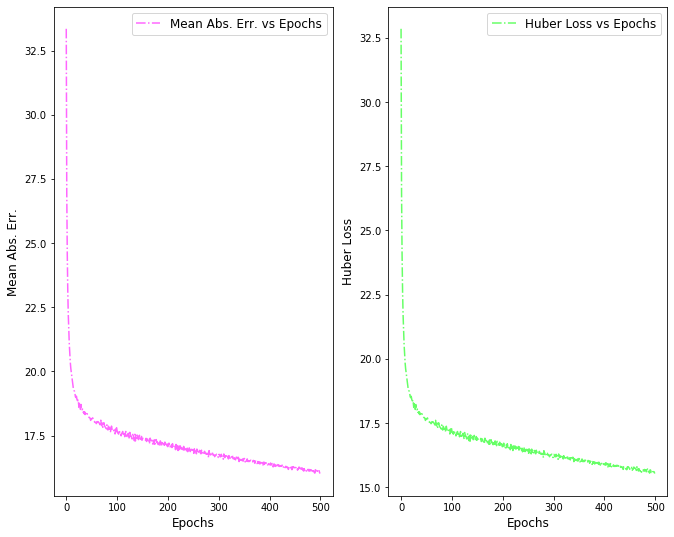

In [0]:
mae_final = history1.history['mae']
loss_final = history1.history['loss']

epochs_final = range(len(loss_final))

fig = plt.figure(figsize=(11, 9))

plt.subplot(1, 2, 1)

plt.plot(epochs_final, mae_final, linestyle='-.', color='magenta', alpha=0.6, label='Mean Abs. Err. vs Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Abs. Err.', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)

plt.plot(epochs_final, loss_final, linestyle='-.', color='lime', alpha=0.6, label='Huber Loss vs Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)
plt.legend(fontsize=12)

plt.show()

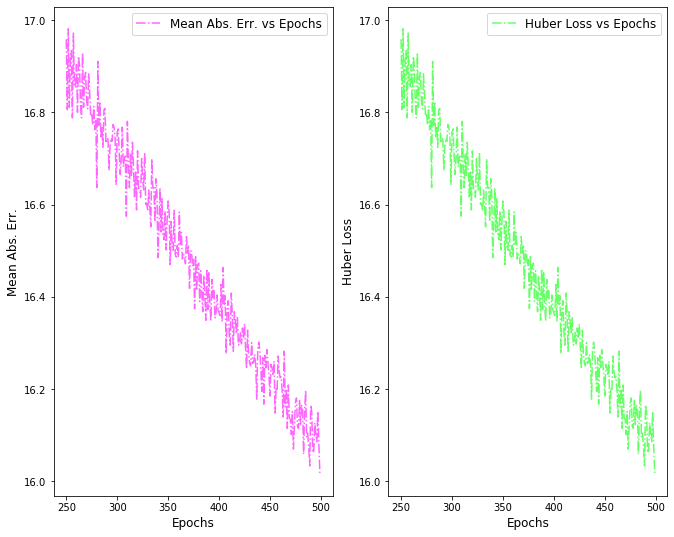

In [0]:
#### Concentrate on the Last Few Epochs

last_epochs = epochs_final[250:]
last_mae_final = mae_final[250:]
last_loss_final = mae_final[250:]

fig = plt.figure(figsize=(11, 9))

plt.subplot(1, 2, 1)

plt.plot(last_epochs, last_mae_final, linestyle='-.', color='magenta', alpha=0.6, label='Mean Abs. Err. vs Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Abs. Err.', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)

plt.plot(last_epochs, last_loss_final, linestyle='-.', color='lime', alpha=0.6, label='Huber Loss vs Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [0]:
def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

In [0]:
tot_dataset=windowed_dataset(sunspot_array, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
print (sunspot_array.shape)
# print ("length of total dataset: ", len(tot_dataset))

(3235, 1)


In [0]:
model1.predict(x_valid[np.newaxis])


array([[-7.33473]], dtype=float32)

In [0]:
forecasts = []
for time in range(len(sunspot_array) - window_size):
  pred = model1.predict(sunspot_array[time:time+window_size][np.newaxis])
  forecasts.append(pred)

print ("check forecast: ", forecasts)  


check forecast:  [array([[171.35931]], dtype=float32), array([[161.53403]], dtype=float32), array([[135.12914]], dtype=float32), array([[126.58087]], dtype=float32), array([[123.38445]], dtype=float32), array([[121.05315]], dtype=float32), array([[93.632195]], dtype=float32), array([[93.20839]], dtype=float32), array([[93.83485]], dtype=float32), array([[91.19222]], dtype=float32), array([[117.9482]], dtype=float32), array([[105.38563]], dtype=float32), array([[98.26188]], dtype=float32), array([[68.91535]], dtype=float32), array([[54.017563]], dtype=float32), array([[65.61922]], dtype=float32), array([[76.83461]], dtype=float32), array([[61.7656]], dtype=float32), array([[74.0805]], dtype=float32), array([[99.02318]], dtype=float32), array([[81.85985]], dtype=float32), array([[86.97397]], dtype=float32), array([[62.22937]], dtype=float32), array([[105.711815]], dtype=float32), array([[78.1192]], dtype=float32), array([[71.65907]], dtype=float32), array([[86.70956]], dtype=float32), ar

In [0]:
print ("length of forecasts: ", len(forecasts))


# plt.figure(figsize=(11, 9))
result_forecast = forecasts[split_time-window_size:]
result_forecast = np.array(result_forecast)[:, 0]
print ("shape of result forecast: ", result_forecast.shape)

length of forecasts:  3215
shape of result forecast:  (235, 1)


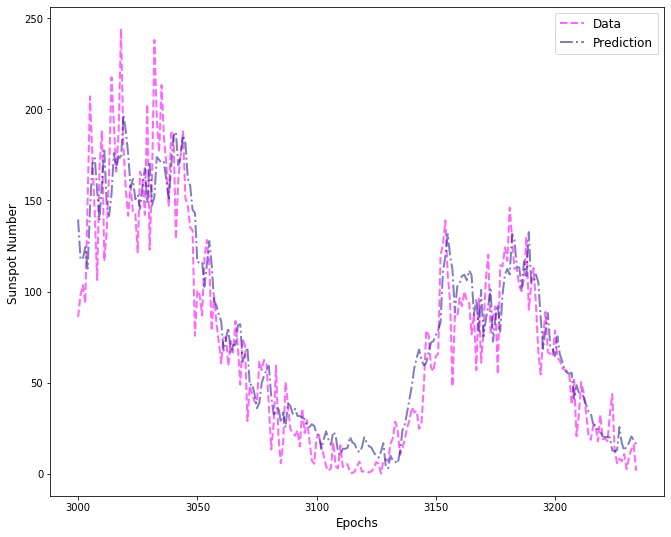

In [0]:
plt.figure(figsize=(11, 9))

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Sunspot Number ", fontsize=12)
plt.plot(time_valid, x_valid, linestyle='--', linewidth=2, color='magenta', alpha=0.6, label='Data')
plt.plot(time_valid, result_forecast, linestyle='-.', linewidth=2, color='navy', alpha=0.5, label='Prediction')
plt.legend(fontsize=12)
plt.show()

In [0]:
print ("mean error: ", tf.keras.metrics.mean_absolute_error(np.squeeze(x_valid), np.squeeze (result_forecast)).numpy())

mean error:  16.44655


In [0]:
print ("Forecast Array: ", result_forecast)

Forecast Array:  [[139.57738  ]
 [117.7904   ]
 [117.91322  ]
 [124.388565 ]
 [112.57775  ]
 [145.50778  ]
 [170.46408  ]
 [173.21028  ]
 [155.1505   ]
 [139.1268   ]
 [160.25111  ]
 [177.40887  ]
 [147.09335  ]
 [141.49158  ]
 [153.12358  ]
 [175.94893  ]
 [167.40506  ]
 [174.34854  ]
 [172.68625  ]
 [196.84428  ]
 [188.23601  ]
 [175.48378  ]
 [157.2096   ]
 [161.81116  ]
 [150.6696   ]
 [153.07948  ]
 [145.38156  ]
 [157.98904  ]
 [167.72214  ]
 [148.69122  ]
 [171.29811  ]
 [147.26733  ]
 [152.12515  ]
 [173.85818  ]
 [172.3439   ]
 [170.54166  ]
 [171.0898   ]
 [160.88309  ]
 [151.10678  ]
 [167.45085  ]
 [185.71054  ]
 [187.65845  ]
 [169.34283  ]
 [174.45073  ]
 [185.58946  ]
 [181.63768  ]
 [162.10393  ]
 [158.22948  ]
 [144.88014  ]
 [143.18764  ]
 [116.16969  ]
 [115.96186  ]
 [116.27863  ]
 [102.64485  ]
 [114.91199  ]
 [127.755424 ]
 [114.929054 ]
 [ 94.99622  ]
 [ 92.377785 ]
 [ 87.34871  ]
 [ 83.73625  ]
 [ 67.50062  ]
 [ 73.971214 ]
 [ 80.01455  ]
 [ 65.99539  ]
 [ 70.47